# Investigating the relationship between ESG scores and stock performance
This notebook investigates the relationship between ESG scores and returns of S&P 500 companies by constructing decile portfolios based on total ESG scores and comparing the performance of top and bottom decile portfolios.

**Methodology:** Top and bottom decile portfolios\
**Ranking:** Total ESG score\
**Weighting:** Equal-weighted\
**Frequency:** Monthly\
**Timeframe:** September 2014 and December 2022 (99 months)\
**Sample size:** 418 S&P 500 companies, chosen based on ESG score data availability

**Data sources:**
- **ESG ratings:** Yahoo Finance via yesg
- **Historical prices:** yfinance
- **Risk-free rate:** fred API (TB3MS)
- **Factor returns:** Fama/French 5 Factors (2x3)

**Risk-adjusted portfolio metrics:**
- Jensen’s alpha
- Information ratio
- 5-Factor alpha
- Sharpe ratio

**Benchmark comparison:** S&P 500

## Imports

In [1]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from datetime import datetime
import time
import pandas_datareader as web
import yfinance as yf
import statsmodels.api as sm
import yesg

## ESG Data
Retrieved ESG scores for S&P500 companies using yesg library. Fetched data is saved as a csv file to avoid fetching again.

### Data Retrieval

In [2]:
# Scrape Wikipedia to get the S&P500 company list
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
sp500_table = tables[0]

# Get the list of symbols and company names
sp500_symbols = sp500_table['Symbol'].tolist()
company_names = sp500_table['Security'].tolist()

print(sp500_symbols)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'C

In [3]:
# Test the yesg module
yesg.get_historic_esg('aapl')

,Total-Score,E-Score,S-Score,G-Score
Date,,,,
2014-09-01,61.00,74.00,45.00,62.00
2014-10-01,60.00,74.00,45.00,62.00
2014-11-01,61.00,74.00,45.00,62.00
2014-12-01,61.00,74.00,45.00,62.00
2015-01-01,61.00,74.00,45.00,62.00
...,...,...,...,...
2022-04-01,NaN,NaN,NaN,NaN
2022-05-01,16.41,0.65,6.86,8.90
2022-06-01,NaN,NaN,NaN,NaN


In [ ]:
# Function to retrieve ESG data for a symbol
def get_esg_data(symbol):
    try:
        esg_data = yesg.get_historic_esg(symbol)
        esg_data['Symbol'] = symbol
        return esg_data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Retrieve ESG data for each symbol in S&P500
esg_data_list = []

for symbol in sp500_symbols:
    esg_data = get_esg_data(symbol)
    
    if esg_data is None:
        print(f"Data not available for {symbol}")
        time.sleep(2)
        continue
    
    esg_data['Symbol'] = symbol
    esg_data_list.append(esg_data)
    print(f"Data fetched for {symbol}")
    time.sleep(2)

In [ ]:
# Concatenate the data into a single dataframe
esg_data_df = pd.concat(esg_data_list, axis=0)
esg_data_df.head()

In [ ]:
# Save the data to a CSV file
esg_data_df.to_csv('data/yesg_sp500.csv', index=False)

### Data Preparation

In [4]:
# Load the saved csv file containing ESG data
esg_data_df = pd.read_csv('data/yesg_sp500.csv')

# Convert the date to datetime format
esg_data_df['Date'] = pd.to_datetime(esg_data_df['Date'])

esg_data_df.head()

,Date,Total-Score,E-Score,S-Score,G-Score,Symbol
0,2014-09-01,73.0,73.0,74.0,73.0,MMM
1,2014-10-01,72.0,72.0,74.0,73.0,MMM
2,2014-11-01,73.0,73.0,74.0,73.0,MMM
3,2014-12-01,73.0,73.0,74.0,73.0,MMM
4,2015-01-01,74.0,70.0,76.0,78.0,MMM


In [5]:
# Check missing data percentage
missing_esg_percent = esg_data_df.isnull().mean().sort_values(ascending=False)
print(missing_esg_percent)

# Missing data percentage per company
missing_esg_by_symbol = esg_data_df.groupby('Symbol').apply(lambda x: x.isnull().mean())
print(missing_esg_by_symbol)

# Missing data by date
missing_esg_by_date = esg_data_df.groupby('Date').apply(lambda x: x.isnull().sum())
print(missing_esg_by_date)

Total-Score    0.207701
E-Score        0.207701
S-Score        0.207701
G-Score        0.207701
Date           0.000000
Symbol         0.000000
dtype: float64
        Date  Total-Score   E-Score   S-Score   G-Score  Symbol
Symbol                                                         
A        0.0     0.217822  0.217822  0.217822  0.217822     0.0
AAL      0.0     0.217822  0.217822  0.217822  0.217822     0.0
AAP      0.0     0.217822  0.217822  0.217822  0.217822     0.0
AAPL     0.0     0.187500  0.187500  0.187500  0.187500     0.0
ABBV     0.0     0.187500  0.187500  0.187500  0.187500     0.0
...      ...          ...       ...       ...       ...     ...
XYL      0.0     0.217822  0.217822  0.217822  0.217822     0.0
YUM      0.0     0.187500  0.187500  0.187500  0.187500     0.0
ZBH      0.0     0.217822  0.217822  0.217822  0.217822     0.0
ZION     0.0     0.000000  0.000000  0.000000  0.000000     0.0
ZTS      0.0     0.187500  0.187500  0.187500  0.187500     0.0

[447 row

- Overall, ~21% of the ESG scores are missing in the dataset. 
- Most stocks have ~22% missing values. 
- There are considerable spikes in missing values in certain periods. 

Let's exclude companies with more than 25% missing ESG scores to reduce potential biases that might rise from incomplete data.

In [6]:
# Filtering out to drop the companies missing more than 25% of the data
threshold = 0.25

# Create a list of companies that meet the threshold
acceptable_symbols = missing_esg_by_symbol[missing_esg_by_symbol['Total-Score'] <= threshold].index

# Check the number of companies that meet the threshold
print(f"Number of companies that meet the threshold: {len(acceptable_symbols)}")

# Filter the original dataframe to only include companies that meet the threshold
filtered_esg_data = esg_data_df[esg_data_df['Symbol'].isin(acceptable_symbols)]

Number of companies that meet the threshold: 420


In [7]:
# Reset the index
filtered_esg_data.reset_index(drop=True, inplace=True)

# Set 'Date' as index again and convert to datetime format
filtered_esg_data.set_index('Date', inplace=True)
filtered_esg_data.index = pd.to_datetime(filtered_esg_data.index)

# Group by 'Symbol' and resample to monthly using the mean value for each month (to align with the monthly returns data)
monthly_esg_data = filtered_esg_data.groupby('Symbol').resample('M').mean()

# Check the missing values again after filtering
missing_data_percent = monthly_esg_data.isnull().mean()
print(missing_data_percent)
print(filtered_esg_data.info())

Total-Score    0.202902
E-Score        0.202902
S-Score        0.202902
G-Score        0.202902
dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40389 entries, 2014-09-01 to 2022-08-01
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total-Score  32194 non-null  float64
 1   E-Score      32194 non-null  float64
 2   S-Score      32194 non-null  float64
 3   G-Score      32194 non-null  float64
 4   Symbol       40389 non-null  object 
dtypes: float64(4), object(1)
memory usage: 1.8+ MB
None


Excluding companies that do not meet the threshold allowed for slight improvement but for a more complete dataset, we need to decide on a method to handle missing values. I decided to use forward filling. Forward filling is an imputation method where we carry the last valid observation down to the next valid. This method assumes that the last available ESG score remains relevant until a new score is reported.

Before applying forward filling, it's important to check for missing values at the start of our time series for each company. If a company's initial value is missing, forward filling won't be effective for that initial entry. Our dataset does not have any missing values at the beginning of the period for all stocks.

It is worth noting that forward filling might not be the perfect solution for all cases, but it's a reasonable approach given the nature of ESG scores, which typically update annually or semi-annually.

In [8]:
# Fill the missing values by carrying the last observation forward
filled_esg_data = monthly_esg_data.groupby('Symbol', group_keys=False).apply(lambda x:x.fillna(method='ffill'))
filled_esg_data.head()

Total-Score  E-Score  S-Score  G-Score
Symbol Date                                              
A      2014-09-30         73.0     83.0     73.0     63.0
       2014-10-31         71.0     83.0     73.0     63.0
       2014-11-30         73.0     83.0     73.0     63.0
       2014-12-31         73.0     83.0     73.0     63.0
       2015-01-31         73.0     83.0     73.0     63.0

In [9]:
# Check missing values again after forward filling
missing_data_percent = filled_esg_data.isnull().mean()
print(missing_data_percent)
print(filled_esg_data.info())

Total-Score    0.0
E-Score        0.0
S-Score        0.0
G-Score        0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40389 entries, ('A', Timestamp('2014-09-30 00:00:00')) to ('ZTS', Timestamp('2022-08-31 00:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total-Score  40389 non-null  float64
 1   E-Score      40389 non-null  float64
 2   S-Score      40389 non-null  float64
 3   G-Score      40389 non-null  float64
dtypes: float64(4)
memory usage: 1.4+ MB
None


## Historical price data
Retrieved time series price data for 418 stocks in S&P500 from yfinance.

### Data Retrieval

In [10]:
# Identify the period in ESG dataset
earliest_date = filtered_esg_data.index.min()
latest_date = filtered_esg_data.index.max()

print(earliest_date)
print(latest_date)

2014-09-01 00:00:00
2023-01-01 00:00:00


In [11]:
# Create list of symbols
symbols = filtered_esg_data['Symbol'].to_list()
# Get historical daily price data from yfinance and calculate daily returns
prices = yf.download(symbols, start=earliest_date, end=latest_date)

prices.head()

[*********************100%***********************]  420 of 420 completed


2 Failed downloads:
['FISV']: Exception("%ticker%: Data doesn't exist for startDate = 1409544000, endDate = 1672549200")
['PKI']: Exception('%ticker%: No timezone found, symbol may be delisted')


Adj Close                                                
                             A        AAL         AAP       AAPL       ABBV   
Date                                                                          
2014-09-02 00:00:00  38.478043  38.277813  126.803772  23.078667  37.835999  \
2014-09-03 00:00:00  38.471416  36.992432  127.190033  22.104574  38.138294   
2014-09-04 00:00:00  38.226265  36.359188  127.162422  21.921381  38.158913   
2014-09-05 00:00:00  38.378651  35.773212  126.693398  22.111277  38.433739   
2014-09-08 00:00:00  38.199745  36.132362  125.810532  21.975002  38.179523   

                                                                             
                           ABC        ABT       ACGL        ACN       ADBE   
Date                                                                         
2014-09-02 00:00:00  67.272369  35.606453  18.510000  69.223953  72.099998  \
2014-09-03 00:00:00  67.455490  36.053333  18.500000  69.855446  72.430000   
2014-09-04 00:00:00  67.446754  36.171364  18.376667  69.770088  72.459999   
2014-09-05 00:00:00  68.135620  36.213524  18.333332  69.829834  73.129997   
2014-09-08 00:00:00  68.301300  36.095501  18.343332  69.744492  73.389999   

                     ...   Volume                                       
                     ...       WY     WYNN      XEL       XOM    XRAY   
Date                 ...                                                
2014-09-02 00:00:00  ...  1858300  4725600  1940600   8957100  398600  \
2014-09-03 00:00:00  ...  3485400  1897900  1599800   8475100  347700   
2014-09-04 00:00:00  ...  2925600  1870700  1189800   9662900  516400   
2014-09-05 00:00:00  ...  4020400  1969800  2122900   9476900  673700   
2014-09-08 00:00:00  ...  2507800  1516900  1377600  10080100  738300   

                                                                   
                         XYL       YUM      ZBH     ZION      ZTS  
Date                                                               
2014-09-02 00:00:00   930900   5995071  1068728  1791000  1654000  
2014-09-03 00:00:00   751000   3645672  1085620  2406200  4220600  
2014-09-04 00:00:00  1065000  10706805  1228893  1979700  2383100  
2014-09-05 00:00:00   528600   4328236   579787  2289800  1602900  
2014-09-08 00:00:00   710500   2432164   850574  1956800  1913500  

[5 rows x 2520 columns]

In [12]:
# Ensure prices data index is in datetime format
prices.index = pd.to_datetime(prices.index)

# Drop the two stocks with no data
prices = prices.dropna(axis=1, how='all')

prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2099 entries, 2014-09-02 to 2022-12-30
Columns: 2508 entries, ('Adj Close', 'A') to ('Volume', 'ZTS')
dtypes: float64(2099), int64(409)
memory usage: 40.2 MB


### Data Preparation

Given that the ESG scores are monthly, we need to resample the daily price data to monthly frequency to calculate monthly returns. The monthly returns are then shifted by one period to get the next month's return. This step is helps us correlate a given month's ESG scores with the subsequent month's returns, with the objective of predicting future returns based on current ESG scores.

In [13]:
# Resample to monthly returns and shift by one period to get next month's return
returns = prices['Adj Close'].resample('M').last().pct_change().shift(-1)[0:]
returns.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-30,-0.029835,0.168371,0.127858,0.071960,0.106880,0.104916,0.053657,0.029240,0.011080,0.013441,...,0.071882,0.015662,0.100987,0.028283,0.113378,0.028238,0.003986,0.106315,-0.003097,0.005683
2014-10-31,0.080871,0.173640,0.000817,0.105979,0.090451,0.069531,0.021105,0.017756,0.064226,0.050770,...,0.042823,-0.046660,0.014042,-0.057040,0.082923,0.054455,0.075456,0.009439,-0.030069,0.211443
2014-11-30,-0.042115,0.105089,0.083355,-0.071891,-0.054335,-0.009775,0.011458,0.031054,0.034518,-0.013301,...,0.016426,-0.167124,0.067320,0.021096,-0.029919,-0.007042,-0.056958,0.012025,0.016037,-0.042288
2014-12-31,-0.075171,-0.084841,-0.001758,0.061424,-0.070858,0.054237,-0.000512,-0.019120,-0.059120,-0.035351,...,-0.001115,-0.005445,0.044822,-0.054408,-0.060822,-0.104281,-0.002190,-0.011638,-0.159593,-0.005104
2015-01-31,0.117553,-0.022065,-0.025598,0.100777,0.002486,0.084300,0.058311,0.020528,0.071403,0.127905,...,-0.012492,-0.027403,-0.059952,0.020435,0.059564,0.051082,0.122164,0.073952,0.117726,0.078633


In [14]:
# Check missing values for each stock in the returns data
missing_values_by_stock = returns.isnull().sum(axis=0).sort_values(ascending=False)

# Missing values for each date in the returns data
missing_values_by_date = returns.isnull().sum(axis=1).sort_values(ascending=False)

missing_values_by_stock.head(10), missing_values_by_date.head(10)

(FOXA    55
 IR      33
 HPE     14
 KHC     11
 PYPL    11
 WRK     10
 ETSY     8
 KEYS     2
 NTAP     1
 NTRS     1
 dtype: int64,
 Date
 2022-12-31    418
 2014-09-30      8
 2014-11-30      7
 2014-10-31      7
 2015-01-31      7
 2015-02-28      7
 2015-03-31      7
 2014-12-31      7
 2015-04-30      6
 2015-05-31      6
 dtype: int64)

Specific stocks exhibited a higher number of missing values such as FOXA, which is missing the returns for 55 months for the 99 month period.

No company in the dataset has values for December 2022. This is expected, as we shifted the data to obtain future returns,  the last month's data will naturally be missing.

We need to take the missing data into consideration during the merging process with the ESG data to ensure the integrity and robustness of the following analysis. 

## Construct decile portfolios based on ESG scores

In [15]:
# Reset the index for filled_esg_data
esg_data_reset = filled_esg_data.reset_index()

# Reset the index for returns
returns_reset = returns.stack().reset_index(level=1).reset_index()

returns_reset.head()

,Date,level_1,0
0,2014-09-30,A,-0.029835
1,2014-09-30,AAL,0.168371
2,2014-09-30,AAP,0.127858
3,2014-09-30,AAPL,0.071960
4,2014-09-30,ABBV,0.106880


I decided to apply an inner merge between the ESG scores and the returns data. This method ensures that the resulting dataset only contains entries where both ESG scores and returns are available. This approach inherently handles missing values in the returns data, as any rows with missing data in either of the datasets will be excluded from the merged result. The missing returns of a particular stock in a particular month will exclude that stock from the decile portfolio and will not influence the returns of that decile.

In [16]:
# Rename columns
returns_reset = returns_reset.rename(columns={'level_1': 'Symbol',0:'Return'})

# Merge the ESG scores and returns
merged_data = pd.merge(esg_data_reset, returns_reset, 
                       left_on=['Date', 'Symbol'], right_on=['Date', 'Symbol'])

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39663 entries, 0 to 39662
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Symbol       39663 non-null  object        
 1   Date         39663 non-null  datetime64[ns]
 2   Total-Score  39663 non-null  float64       
 3   E-Score      39663 non-null  float64       
 4   S-Score      39663 non-null  float64       
 5   G-Score      39663 non-null  float64       
 6   Return       39663 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.1+ MB


While the inner merge provides a neat way of handling missing values, it's important to be aware of its implications. By excluding rows with missing data, we might inadvertently introduce biases if the missing values are not random.

For this analysis, the missing values in the returns data does appear to be random. A sensitivity analysis can be done to ensure the excluded values do not have any patterns that might skew the results.

In [17]:
# Calculate deciles based on the ESG scores
merged_data['Decile'] = merged_data.groupby('Date')['Total-Score'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

merged_data.head()

,Symbol,Date,Total-Score,E-Score,S-Score,G-Score,Return,Decile
0,A,2014-09-30,73.0,83.0,73.0,63.0,-0.029835,9
1,A,2014-10-31,71.0,83.0,73.0,63.0,0.080871,8
2,A,2014-11-30,73.0,83.0,73.0,63.0,-0.042115,9
3,A,2014-12-31,73.0,83.0,73.0,63.0,-0.075171,9
4,A,2015-01-31,73.0,83.0,73.0,63.0,0.117553,9


In [18]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39663 entries, 0 to 39662
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Symbol       39663 non-null  object        
 1   Date         39663 non-null  datetime64[ns]
 2   Total-Score  39663 non-null  float64       
 3   E-Score      39663 non-null  float64       
 4   S-Score      39663 non-null  float64       
 5   G-Score      39663 non-null  float64       
 6   Return       39663 non-null  float64       
 7   Decile       39663 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 2.4+ MB


## Calculate top and bottom decile portfolio returns, their return difference, and t-statistic

In [19]:
# Calculate the average return for each decile portfolio (equal-weighted portfolio)
decile_returns = merged_data.groupby(['Date', 'Decile']).mean(numeric_only=True)
decile_returns

Total-Score    E-Score    S-Score    G-Score    Return
Date       Decile                                                        
2014-09-30 0         46.106383  40.085106  45.382979  55.553191  0.056174
           1         50.093023  44.906977  50.232558  57.162791  0.041964
           2         53.073171  47.097561  53.414634  61.658537  0.036039
           3         56.121951  53.414634  54.341463  62.560976  0.040991
           4         58.586207  57.827586  56.586207  63.482759  0.033114
...                        ...        ...        ...        ...       ...
2022-11-30 5         21.440000   5.989048   8.084286   7.366190 -0.026934
           6         23.613182   6.449091  10.008636   7.155909 -0.035209
           7         26.351905   7.956667  10.916190   7.478571 -0.060180
           8         29.285455  11.891364  10.622727   6.771818 -0.050205
           9         34.323333  14.542381  12.370476   7.410952 -0.062688

[990 rows x 5 columns]

In [20]:
# Unstack the decile returns
decile_returns_unstacked = decile_returns.unstack(level=-1)
decile_returns_unstacked.head()

Total-Score                                                          
Decile               0          1          2          3          4          5   
Date                                                                            
2014-09-30   46.106383  50.093023  53.073171  56.121951  58.586207  61.090909  \
2014-10-31   46.125000  50.155556  52.607143  55.529412  58.551724  61.021277   
2014-11-30   46.282609  50.024390  53.022222  56.000000  58.888889  61.388889   
2014-12-31   46.217391  50.105263  52.976190  55.976190  58.972222  61.432432   
2015-01-31   46.945455  51.078947  53.914286  56.352941  59.716981  62.393939   

                                                        ...    Return   
Decile              6          7          8          9  ...         0   
Date                                                    ...             
2014-09-30  63.976190  66.500000  69.795455  75.777778  ...  0.056174  \
2014-10-31  63.562500  65.878049  69.300000  74.789474  ...  0.037186   
2014-11-30  64.086957  66.902439  70.323529  75.916667  ... -0.006188   
2014-12-31  64.081633  66.974359  70.457143  76.028571  ...  0.005468   
2015-01-31  64.414634  66.868421  70.342857  76.054054  ...  0.053208   

                                                                         
Decile             1         2         3         4         5         6   
Date                                                                     
2014-09-30  0.041964  0.036039  0.040991  0.033114  0.049496  0.041050  \
2014-10-31  0.036195  0.003008  0.038107  0.041980  0.021892  0.023973   
2014-11-30  0.008656  0.004119 -0.005196  0.008014  0.003843  0.007555   
2014-12-31 -0.015189 -0.029012 -0.043375 -0.007891 -0.017401 -0.016587   
2015-01-31  0.082332  0.048536  0.054844  0.055916  0.050942  0.052532   

                                          
Decile             7         8         9  
Date                                      
2014-09-30  0.045423  0.036112  0.025067  
2014-10-31  0.041112  0.040359  0.038842  
2014-11-30  0.014778  0.017923  0.003952  
2014-12-31 -0.040073 -0.001529 -0.030227  
2015-01-31  0.058070  0.055286  0.034847  

[5 rows x 50 columns]

In [21]:
# Calculate the cumulative returns of the top and bottom portfolios
top_cum_ret = (1 + decile_returns_unstacked[('Return', 9)]).cumprod()
bottom_cum_ret = (1 + decile_returns_unstacked[('Return', 0)]).cumprod()

In [22]:
# Calculate the return difference between the top and bottom portfolios
return_diff = decile_returns_unstacked[('Return', 9)] - decile_returns_unstacked[('Return', 0)]

# Calculate the standard deviation of the returns for each decile
decile_returns_std = merged_data.groupby(['Date', 'Decile'])['Return'].std()
decile_returns_std_unstacked = decile_returns_std.unstack(level=-1)

# Calculate the t-statistic for the return difference
n_top = merged_data[merged_data['Decile'] == 9].shape[0]
n_bottom = merged_data[merged_data['Decile'] == 0].shape[0]
se_return_diff = np.sqrt((decile_returns_std_unstacked[9]**2/n_top) + (decile_returns_std_unstacked[0]**2/n_bottom))
t_stat = return_diff/se_return_diff

In [23]:
# Calculate summary statistics for the top and bottom portfolios
top_portfolio_stats = decile_returns_unstacked[('Return', 9)].describe()
bottom_portfolio_stats = decile_returns_unstacked[('Return', 0)].describe()

# Print the results
print('Summary statistics for the top portfolio:')
print(top_portfolio_stats)
print('----------------------------------------')
print('Summary statistics for the bottom portfolio:')
print(bottom_portfolio_stats)

Summary statistics for the top portfolio:
count    99.000000
mean      0.015529
std       0.060372
min      -0.239362
25%      -0.008329
50%       0.014718
75%       0.040317
max       0.230885
Name: (Return, 9), dtype: float64
----------------------------------------
Summary statistics for the bottom portfolio:
count    99.000000
mean      0.011586
std       0.051423
min      -0.186615
25%      -0.008181
50%       0.014530
75%       0.041965
max       0.149056
Name: (Return, 0), dtype: float64


In [24]:
# Calculate the average returns
top_average_ret = decile_returns_unstacked[('Return', 9)].mean()
bottom_average_ret = decile_returns_unstacked[('Return', 0)].mean()

# Calculate the standard deviation of returns
top_std = decile_returns_std_unstacked[9].mean()
bottom_std = decile_returns_std_unstacked[0].mean()

# Calculate the average return difference
average_return_diff = return_diff.mean()

# Calculate the standard deviation of the return difference
std_return_diff = return_diff.std()

# Calculate the t-statistic using the average return difference and standard error
average_se_return_diff = se_return_diff.mean()
average_t_stat = average_return_diff / average_se_return_diff

# Create the summary table
summary_table = pd.DataFrame({
    'Portfolio': ['TOP', 'BOT', 'DIF'],
    'Average Return': [top_average_ret, bottom_average_ret, average_return_diff],
    'Standard Deviation': [top_std, bottom_std, std_return_diff],
    'T-Statistic': ['-', '-', average_t_stat]
})

summary_table

,Portfolio,Average Return,Standard Deviation,T-Statistic
0,TOP,0.015529,0.074081,-
1,BOT,0.011586,0.064602,-
2,DIF,0.003943,0.031596,2.491995


## Calculate CAPM alpha

In [25]:
# Retrieve historical risk-free rate from fred
rf = web.DataReader('TB3MS', 'fred',start=earliest_date,end=latest_date)

# Convert to monthly rates
rf = (1 + (rf / 100)) ** (1 / 12) - 1 
rf = rf.resample('M').last().shift(-1)

# Check for missing values
rf.isnull().sum()

TB3MS    1
dtype: int64

In [26]:
rf.head()

,TB3MS
DATE,
2014-09-30,0.000017
2014-10-31,0.000017
2014-11-30,0.000025
2014-12-31,0.000025
2015-01-31,0.000017


In [27]:
# Retrieve market returns
sp500 = yf.download('SPY',start=earliest_date, end=latest_date) 

# Convert to monthly and shift by one period to get next month's return
market_ret = sp500['Adj Close'].resample('M').last().pct_change().shift(-1)[0:]

# Check for missing values
market_ret.isnull().sum()

[*********************100%***********************]  1 of 1 completed


1

In [28]:
market_ret.head()

Date
2014-09-30    0.023551
2014-10-31    0.027472
2014-11-30   -0.002537
2014-12-31   -0.029629
2015-01-31    0.056204
Freq: M, Name: Adj Close, dtype: float64

In [29]:
# Merge top decile returns, bottom decile returns, market returns, and risk-free rates
all = pd.concat([
    decile_returns_unstacked[('Return', 9)].to_frame('Top_Returns'),
    decile_returns_unstacked[('Return', 0)].to_frame('Bottom_Returns'),
    market_ret.to_frame('Market_Returns'),
    rf.rename(columns = {'TB3MS':'Risk_Free_Rates'})
], axis=1)

# Calculate excess returns
all['Top_Excess_Returns'] = all['Top_Returns'] - all['Risk_Free_Rates']
all['Bottom_Excess_Returns'] = all['Bottom_Returns'] - all['Risk_Free_Rates']
all['Market_Excess_Returns'] = all['Market_Returns'] - all['Risk_Free_Rates']

all.head()

,Top_Returns,Bottom_Returns,Market_Returns,Risk_Free_Rates,Top_Excess_Returns,Bottom_Excess_Returns,Market_Excess_Returns
2014-09-30,0.025067,0.056174,0.023551,0.000017,0.025050,0.056157,0.023534
2014-10-31,0.038842,0.037186,0.027472,0.000017,0.038825,0.037170,0.027455
2014-11-30,0.003952,-0.006188,-0.002537,0.000025,0.003927,-0.006213,-0.002562
2014-12-31,-0.030227,0.005468,-0.029629,0.000025,-0.030252,0.005443,-0.029654
2015-01-31,0.034847,0.053208,0.056204,0.000017,0.034830,0.053191,0.056188


In [30]:
# Drop missing values
all = all.dropna()
all.shape

(99, 7)

In [31]:
# Run linear regression to estimate CAPM alpha for top and bottom decile portfolios
top_X = sm.add_constant(all['Market_Excess_Returns'])
top_model = sm.OLS(all['Top_Excess_Returns'], top_X).fit()
top_alpha = top_model.params['const']

bottom_X = sm.add_constant(all['Market_Excess_Returns'])
bottom_model = sm.OLS(all['Bottom_Excess_Returns'], bottom_X).fit()
bottom_alpha = bottom_model.params['const']

print(top_model.summary())

print(bottom_model.summary())

                            OLS Regression Results                            
Dep. Variable:     Top_Excess_Returns   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     305.2
Date:                Thu, 20 Jul 2023   Prob (F-statistic):           1.02e-31
Time:                        16:42:51   Log-Likelihood:                 208.26
No. Observations:                  99   AIC:                            -412.5
Df Residuals:                      97   BIC:                            -407.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

The R-squared values suggest that the CAPM model explains 76% of the variance in the top portfolio returns and 89% of the variance in the bottom portfolio returns. This indicates a good fit for the model, particularly for the bottom portfolio. The F-statistics are large and far above 1, indicating that the overall model is significant for both portfolios. However, the p- values for the alphas (intercepts) in both models are above 0.05, suggesting that the CAPM alpha is not significantly different from zero for either portfolio. This means that, according to the CAPM model, neither portfolio generates significant abnormal returns after adjusting for market risk.

In [32]:
# Calculate alpha difference
alpha_diff = top_alpha - bottom_alpha

# Calculate standard errors of alphas
top_alpha_se = top_model.bse['const']
bottom_alpha_se = bottom_model.bse['const']

# Calculate standard error of the difference
se_alpha_diff = np.sqrt(top_alpha_se**2 + bottom_alpha_se**2)

# Calculate t-statistic
t_stat_alpha = alpha_diff / se_alpha_diff

In [33]:
# Add to summary table
summary_table['CAPM Alpha'] = [top_alpha, bottom_alpha, alpha_diff]
summary_table['T-Statistic(Alpha)'] = ['-', '-', t_stat_alpha]

summary_table

,Portfolio,Average Return,Standard Deviation,T-Statistic,CAPM Alpha,T-Statistic(Alpha)
0,TOP,0.015529,0.074081,-,0.004879,-
1,BOT,0.011586,0.064602,-,0.001682,-
2,DIF,0.003943,0.031596,2.491995,0.003197,0.910388


In [34]:
print('t-statistic for return difference: ' + str(average_t_stat))
print('t-statistic for alpha difference: ' + str(t_stat_alpha))

t-statistic for return difference: 2.4919949937976598
t-statistic for alpha difference: 0.91038809242106


## Calculate information ratio

In [35]:
top_ir = all['Top_Excess_Returns'].mean() / all['Top_Excess_Returns'].std()
bottom_ir = all['Bottom_Excess_Returns'].mean() / all['Bottom_Excess_Returns'].std()
ir_diff = top_ir - bottom_ir

In [36]:
# Add to summary table
summary_table['Information Ratio'] = [top_ir, bottom_ir, ir_diff]
summary_table.set_index('Portfolio')

,Average Return,Standard Deviation,T-Statistic,CAPM Alpha,T-Statistic(Alpha),Information Ratio
Portfolio,,,,,,
TOP,0.015529,0.074081,-,0.004879,-,0.244168
BOT,0.011586,0.064602,-,0.001682,-,0.209851
DIF,0.003943,0.031596,2.491995,0.003197,0.910388,0.034317


## Calculate 5-factor alpha

In [37]:
# Date parser function
def parse_date(date_str):
    return pd.to_datetime(date_str, format='%Y%m')

# Read the Fama French 5-factor data
ff5_data = pd.read_csv('data/FF_5_Factors.csv', header=2, parse_dates=[0], 
                       index_col=0, date_parser=parse_date, nrows=716)

ff5_data.head()

/var/folders/47/h5_s7vcs6dqdzfk1gltbb0p80000gn/T/ipykernel_65899/683635668.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5_data = pd.read_csv('data/FF_5_Factors.csv', header=2, parse_dates=[0],


,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27


In [38]:
# Convert the factor returns from percentage to decimal
ff5_data = ff5_data / 100

# Matching the dates
ff5_data.index = ff5_data.index.to_period('M').to_timestamp('M')
ff5_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027


In [39]:
# Merge the dataframes
ff_ret = all.merge(ff5_data, left_index=True, right_index=True)
ff_ret.head()

,Top_Returns,Bottom_Returns,Market_Returns,Risk_Free_Rates,Top_Excess_Returns,Bottom_Excess_Returns,Market_Excess_Returns,Mkt-RF,SMB,HML,RMW,CMA,RF
2014-09-30,0.025067,0.056174,0.023551,0.000017,0.025050,0.056157,0.023534,-0.0197,-0.0373,-0.0134,0.0131,-0.0049,0.0
2014-10-31,0.038842,0.037186,0.027472,0.000017,0.038825,0.037170,0.027455,0.0252,0.0372,-0.0181,-0.0055,-0.0009,0.0
2014-11-30,0.003952,-0.006188,-0.002537,0.000025,0.003927,-0.006213,-0.002562,0.0255,-0.0228,-0.0309,0.0150,0.0026,0.0
2014-12-31,-0.030227,0.005468,-0.029629,0.000025,-0.030252,0.005443,-0.029654,-0.0006,0.0286,0.0227,-0.0122,0.0096,0.0
2015-01-31,0.034847,0.053208,0.056204,0.000017,0.034830,0.053191,0.056188,-0.0311,-0.0091,-0.0358,0.0160,-0.0166,0.0


In [40]:
# Set the float display
pd.set_option('display.float_format', '{:.4f}'.format)

In [41]:
# Run the 5-factor regression for the top decile portfolio
top_X = sm.add_constant(ff_ret[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
top_5f_model = sm.OLS(ff_ret['Top_Excess_Returns'], top_X).fit()
top_5f_alpha = top_model.params['const']

# Run the 5-factor regression for the bottom decile portfolio
bottom_X = sm.add_constant(ff_ret[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
bottom_5f_model = sm.OLS(ff_ret['Bottom_Excess_Returns'], bottom_X).fit()
bottom_5f_alpha = bottom_model.params['const']

print('Top decile 5-factor alpha:', top_5f_alpha)
print('Bottom decile 5-factor alpha:', bottom_5f_alpha)
print(top_5f_model.summary())
print(bottom_5f_model.summary())

Top decile 5-factor alpha: 0.0048790929223861265
Bottom decile 5-factor alpha: 0.0016822253973856015
                            OLS Regression Results                            
Dep. Variable:     Top_Excess_Returns   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2.089
Date:                Thu, 20 Jul 2023   Prob (F-statistic):             0.0736
Time:                        16:43:17   Log-Likelihood:                 143.12
No. Observations:                  99   AIC:                            -274.2
Df Residuals:                      93   BIC:                            -258.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

For the 5-Factor model, the R-squared values are quite low for both portfolios, indicating that the Fama-French 5-factor model explains only a small portion of the variance in the portfolio returns. The F-statistics are also low, particularly for the bottom portfolio, suggesting that the overall model might not be very significant. The p-values for the alphas in the 5-factor model are below 5% for the top portfolio and just above 5% for the bottom portfolio. This suggests that the top portfolio has a statistically significant 5-factor alpha at the 5% level, while the bottom portfolio does not. This means that, according to the 5-factor model, the top portfolio generates significant abnormal returns after adjusting for the risk factors included in the model. In conclusion, the top decile portfolio appears to generate higher average returns and a higher 5-factor alpha than the bottom decile portfolio, although the difference is not statistically significant. According to the CAPM model, neither portfolio generates significant abnormal returns.

In [42]:
# Calculate 5-factor alpha difference
alpha_diff_5f = top_5f_alpha - bottom_5f_alpha

# Calculate standard errors of top and bottom 5-factor alphas
top_5f_alpha_se = top_5f_model.bse['const']
bottom_5f_alpha_se = bottom_5f_model.bse['const']

# Calculate the standard error of the difference in 5-factor alphas
alpha_diff_5f_se = np.sqrt(top_5f_alpha_se**2 + bottom_5f_alpha_se**2)

t_stat_5f_alpha = alpha_diff_5f / alpha_diff_5f_se

In [43]:
# Add to summary table
summary_table['5-Factor Alpha'] = [top_5f_alpha, bottom_5f_alpha, alpha_diff_5f]
summary_table['T-Statistic(5-F Alpha)'] = ['-','-',t_stat_5f_alpha]
summary_table

,Portfolio,Average Return,Standard Deviation,T-Statistic,CAPM Alpha,T-Statistic(Alpha),Information Ratio,5-Factor Alpha,T-Statistic(5-F Alpha)
0,TOP,0.0155,0.0741,-,0.0049,-,0.2442,0.0049,-
1,BOT,0.0116,0.0646,-,0.0017,-,0.2099,0.0017,-
2,DIF,0.0039,0.0316,2.4920,0.0032,0.9104,0.0343,0.0032,0.3915


## Calculate Sharpe ratio

In [44]:
# Calculate the average excess returns and standard deviations
top_avg_excess_return = all['Top_Excess_Returns'].mean()
bottom_avg_excess_return = all['Bottom_Excess_Returns'].mean()
top_std_excess_return = all['Top_Excess_Returns'].std()
bottom_std_excess_return = all['Bottom_Excess_Returns'].std()

# Calculate Sharpe ratios
top_sharpe_ratio = top_avg_excess_return / top_std_excess_return
bottom_sharpe_ratio = bottom_avg_excess_return / bottom_std_excess_return

print("Top Decile Sharpe Ratio:", top_sharpe_ratio)
print("Bottom Decile Sharpe Ratio:", bottom_sharpe_ratio)

# Add to summary table
summary_table['Sharpe Ratio'] = [top_sharpe_ratio, bottom_sharpe_ratio, top_sharpe_ratio - bottom_sharpe_ratio]
summary_table

Top Decile Sharpe Ratio: 0.244167869423719
Bottom Decile Sharpe Ratio: 0.2098512142413897


,Portfolio,Average Return,Standard Deviation,T-Statistic,CAPM Alpha,T-Statistic(Alpha),Information Ratio,5-Factor Alpha,T-Statistic(5-F Alpha),Sharpe Ratio
0,TOP,0.0155,0.0741,-,0.0049,-,0.2442,0.0049,-,0.2442
1,BOT,0.0116,0.0646,-,0.0017,-,0.2099,0.0017,-,0.2099
2,DIF,0.0039,0.0316,2.4920,0.0032,0.9104,0.0343,0.0032,0.3915,0.0343


The top ESG-based portfolio has slightly outperformed the bottom ESG-based portfolio in terms of average returns, CAPM alpha, and Fama French 5-factor alpha. The t-statistic of 2.492 for the difference in average returns suggests that the difference is statistically significant. This indicates that the top and bottom decile portfolios have significantly different average returns. However, the t-statistic for the differences in CAPM alpha and 5-factor alpha is not statistically significant, suggesting that the difference in risk-adjusted performance could be due to random fluctuations.

## Visualizations

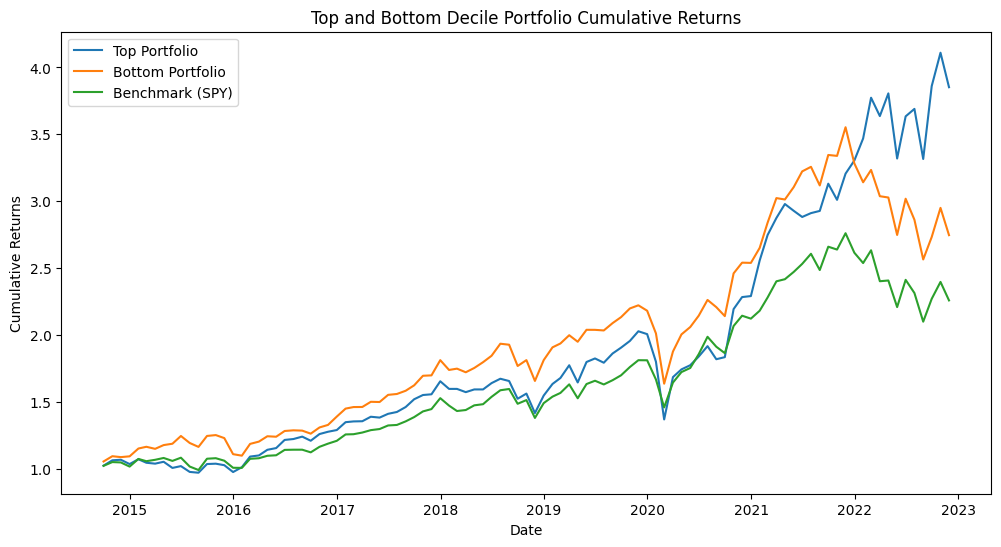

In [45]:
# Calculate cumulative returns for the market
market_cum_ret = (1+all['Market_Returns']).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.title('Top and Bottom Decile Portfolio Cumulative Returns')
plt.plot(top_cum_ret, label='Top Portfolio')
plt.plot(bottom_cum_ret, label='Bottom Portfolio')
plt.plot(market_cum_ret, label='Benchmark (SPY)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

As seen in the chart, both the top and bottom ESG portfolios have largely outperformed the S&P 500 over the timeframe of our study. Interestingly, the top decile ESG portfolio underperformed relative to the bottom one until 2022, but it seems to be gaining momentum and starting to outperform in the subsequent period. This could be an indication of the growing importance of ESG factors in driving investment performance.

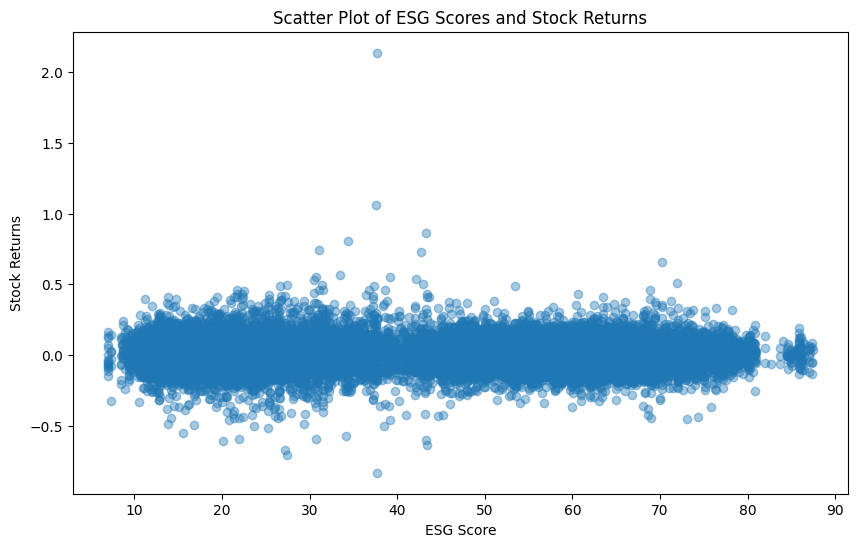

In [46]:
# Create a scatter plot of ESG scores and returns
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Total-Score'], merged_data['Return'], alpha=0.4)
plt.xlabel('ESG Score')
plt.ylabel('Stock Returns')
plt.title('Scatter Plot of ESG Scores and Stock Returns')
plt.show()

According to the scatter plot, there does not appear to be a significant statistical relationship between ESG scores and returns for our sample. The data points are dispersed widely, suggesting that high ESG scores do not necessarily correspond to higher returns.

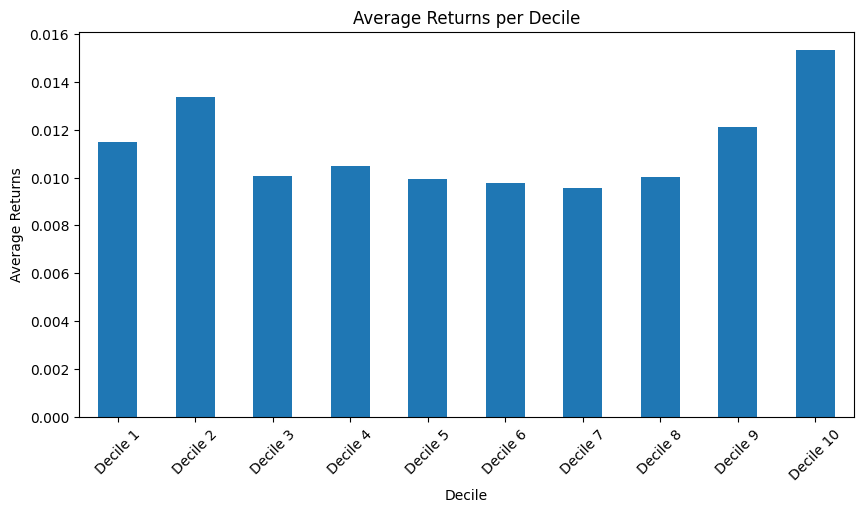

In [47]:
# Calculate the average returns for each decile
average_returns = merged_data.groupby('Decile')['Return'].mean()

# Plot a bar chart of average returns per decile
plt.figure(figsize=(10, 5))
average_returns.plot(kind='bar')
plt.xlabel('Decile')
plt.ylabel('Average Returns')
plt.title('Average Returns per Decile')
plt.xticks(range(10), [f'Decile {i}' for i in range(1, 11)], rotation=45)
plt.show()

The bar chart above reveals that the difference between the top and bottom deciles is minimal, with the middle decile exhibiting lower returns than both. However, when focusing on the period from 2018 onwards as seen below, the difference between the top and bottom deciles becomes more pronounced, indicating that the relationship between ESG scores and returns may have evolved over time. Same trend can also be seen in the rolling CAPM alpha chart at the end of the notebook.

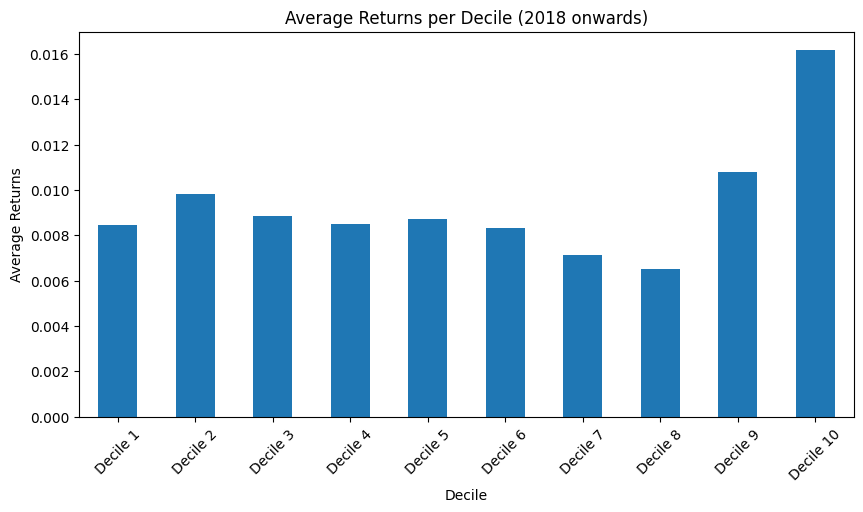

In [48]:
# Filter data for more recent years
recent_years = merged_data.loc[merged_data['Date'] >= '2018']

# Calculate the average returns for each decile
average_returns_recent = recent_years.groupby('Decile')['Return'].mean()

# Plot the bar chart for recent years
plt.figure(figsize=(10, 5))
average_returns_recent.plot(kind='bar')
plt.xlabel('Decile')
plt.ylabel('Average Returns')
plt.title('Average Returns per Decile (2018 onwards)')
plt.xticks(range(10), [f'Decile {i}' for i in range(1, 11)], rotation=45)
plt.show()


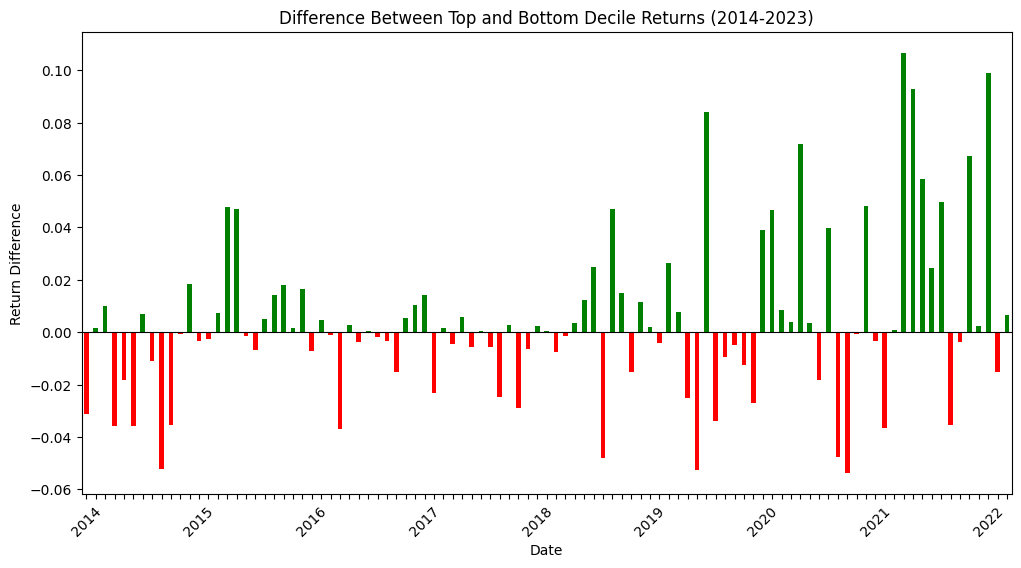

In [49]:
# Plot the line chart for the difference between top and bottom decile returns
fig, ax = plt.subplots(figsize=(12, 6))
return_diff.plot(kind='bar',color=np.where(return_diff > 0, 'g', 'r'),ax=ax)
ax.axhline(0, color='black', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('Return Difference')
plt.title('Difference Between Top and Bottom Decile Returns (2014-2023)')

ax.set_xticklabels([label if i%12 == 0 else '' for i, label in enumerate(return_diff.index.year)], rotation=45)
plt.show()

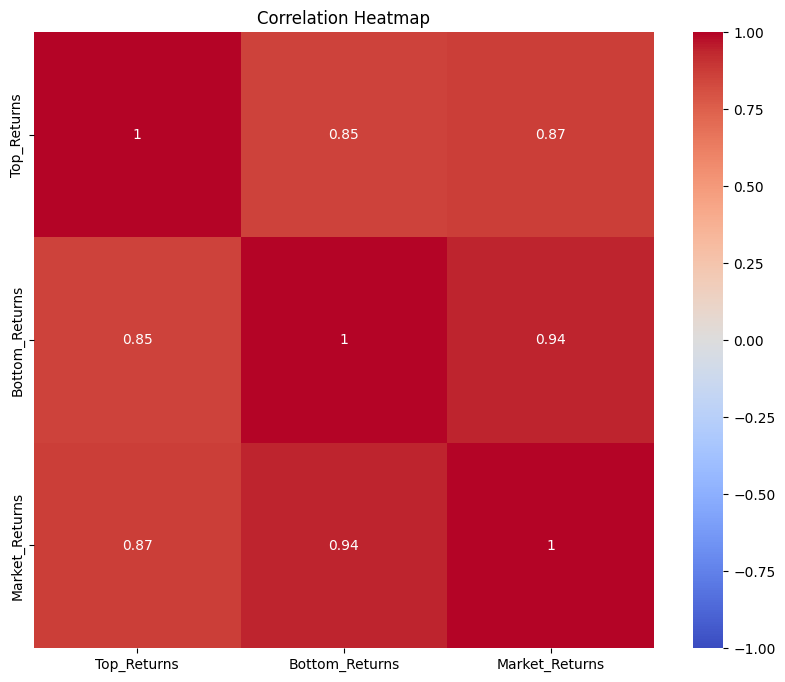

In [50]:
# Calculate correlations between ESG scores, stock returns, market returns, risk-free rates, and excess returns
correlations = all[['Top_Returns', 'Bottom_Returns', 'Market_Returns']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

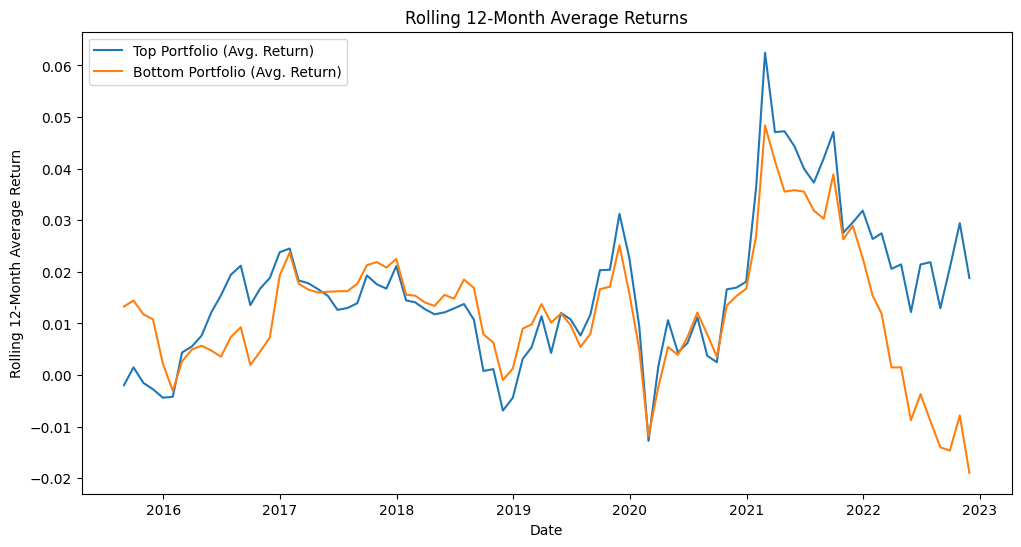

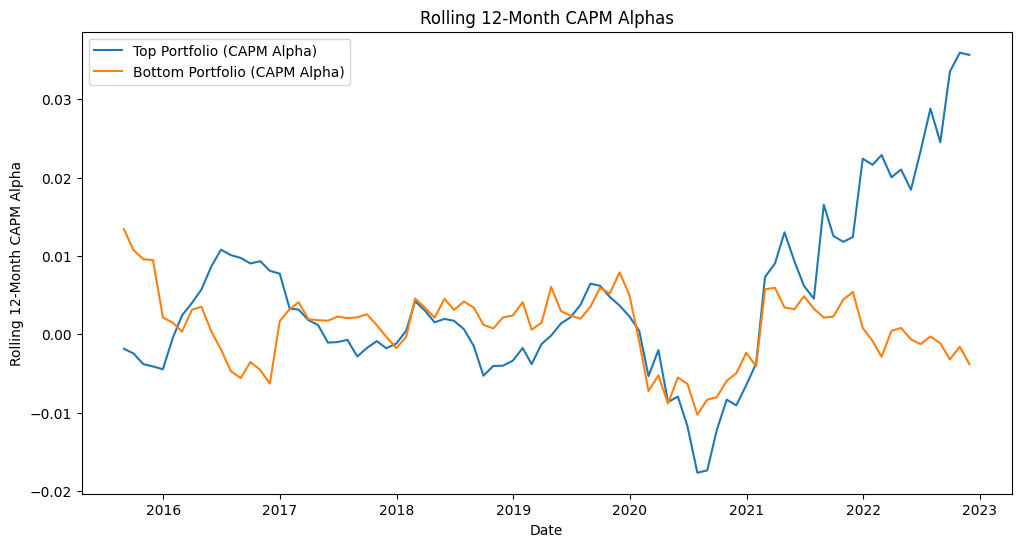

In [51]:
# Calculate rolling average returns for top and bottom decile portfolios
top_rolling_avg_return = all['Top_Returns'].rolling(window=12).mean()
bottom_rolling_avg_return = all['Bottom_Returns'].rolling(window=12).mean()

# Calculate rolling CAPM alphas for top and bottom decile portfolios
top_rolling_alpha = all['Top_Excess_Returns'].rolling(window=12).apply(lambda x: sm.OLS(x, sm.add_constant(all.loc[x.index, 'Market_Excess_Returns'])).fit().params['const'])
bottom_rolling_alpha = all['Bottom_Excess_Returns'].rolling(window=12).apply(lambda x: sm.OLS(x, sm.add_constant(all.loc[x.index, 'Market_Excess_Returns'])).fit().params['const'])

# Plot rolling average returns
plt.figure(figsize=(12, 6))
plt.plot(top_rolling_avg_return, label='Top Portfolio (Avg. Return)')
plt.plot(bottom_rolling_avg_return, label='Bottom Portfolio (Avg. Return)')
plt.xlabel('Date')
plt.ylabel('Rolling 12-Month Average Return')
plt.legend()
plt.title('Rolling 12-Month Average Returns')
plt.show()

# Plot rolling CAPM alphas
plt.figure(figsize=(12, 6))
plt.plot(top_rolling_alpha, label='Top Portfolio (CAPM Alpha)')
plt.plot(bottom_rolling_alpha, label='Bottom Portfolio (CAPM Alpha)')
plt.xlabel('Date')
plt.ylabel('Rolling 12-Month CAPM Alpha')
plt.legend()
plt.title('Rolling 12-Month CAPM Alphas')
plt.show()

## Limitations:

1. **Data completeness**: The analysis is based on the available ESG scores and stock returns data. There might be external factors or events not captured by the datasets that could influence stock returns.

2. **Handling missing data**: Used forward filling for ESG scores, and applied an inner merge which excluded missing returns data. Different methods can yield different results.

3. **ESG scoring**: The ESG scores represent a specific methodology's output, and different providers or methodologies might yield different scores for the same firm. The results here rely on the ESG score dataset from Yahoo Finance.

4. **Causality**: Correlation does not imply causation. There could be other variables or factors influencing the observed relationships.

5. **Time horizon**: The analysis focuses on monthly returns between September 2014 and December 2022. The relationship between ESG scores and returns might vary over different investment horizons.